In [1]:
!pip install deepctr-torch
!pip install lightgbm
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 82 kB 793 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 4.8 MB/s 
     |████████████████████████████████| 81 kB 5.2 MB/s 
     |████████████████████████████████| 209 kB 42.1 MB/s 
     |████████████████████████████████| 78 kB 2.1 MB/s 
     |████████████████████████████████| 50 kB 666 kB/s 
     |████████████████████████████████| 147 kB 71.7 MB/s 
     |████████████████████████████████| 112 kB 56.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=f97ffa3cca4a2fe781220027db041d10b952d912a8fc3f5c4f9d08cbe31bf4cc
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a03678

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


데이터 압축 풀기

In [3]:
import os
os.chdir('/content/drive/MyDrive/YDS/AIConnect_YDS_2')

In [4]:
# rm -rf Train

In [5]:
# !unzip train.zip

In [6]:
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer,MinMaxScaler
import matplotlib.pyplot as plt
from deepctr_torch.inputs import SparseFeat, get_feature_names, DenseFeat
from deepctr_torch.models import DeepFM
from sklearn.metrics import mean_absolute_error
import numpy as np
from lightgbm import LGBMRegressor,plot_importance,Dataset

In [7]:
# Main Train 파일 로드
Ori_Train = pd.read_csv('./Train/Train.csv',encoding='utf-8')
# 엑셀파일이기에 read_excel로 로드
Sub_Data = pd.read_excel('./Train/ETC_Data/Main_Subjects.xlsx')

In [8]:
Ori_Train[:20]

,Unnamed: 0,USER_ID,REG_DATE,TOTAL_RATE,TX_RATE,SERVICE_RATE,ETC_RATE,CONTENTS,HOSPITAL_CD,HOSPITAL_NM,...,시도코드명,시군구코드,시군구코드명,전화번호,병원홈페이지(URL),개설일자,총의사수,x좌표,y좌표,Identity_Key
0,0,4.778650e+05,2018-07-23 09:24:08,9.0,8.0,10.0,8.0,볼지방제거와 밴드리프팅 한지 한달됐어요 많이 가름해졌어요 좀더 지켜봐야 할것같다,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,서울,110001,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,477865_85156
1,1,2.010333e+11,2018-07-23 09:59:15,10.0,10.0,10.0,10.0,너무좋은데. 아직 좀지켜봐야알겠지만 예뻐질것같은 느낌이예요,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,서울,110001,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,201033325523_85156
2,2,3.381810e+05,2018-07-23 10:00:57,10.0,10.0,10.0,10.0,꼭당첨!!!,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,서울,110001,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,338181_85156
3,3,2.010326e+11,2018-07-24 12:57:55,5.0,6.0,6.0,4.0,무제한 보톡스 는 아닌것 같아요 보톡스를 맞기 위한 옷 이 없어 기다림 남이 입건것...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,서울,110001,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,201032630325_85156
4,4,4.998490e+05,2018-07-25 10:08:18,10.0,10.0,10.0,10.0,NaN,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,서울,110001,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,499849_85156
5,5,5.082850e+05,2018-07-25 10:35:27,3.0,2.0,2.0,6.0,효과 1도 없고 그냥 돈버림 시술해준 원장님도 완전 불친절 원장님이 먼저 상담하고 ...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,서울,110001,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,508285_85156
6,6,2.010546e+11,2018-07-27 08:34:42,10.0,10.0,10.0,10.0,정말 잘선택했습니다 역시 메이크입니다 굿닥보고 후기보고 세종에서 서울로 힘은들었지...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,서울,110001,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,201054586083_85156
7,7,2.010951e+11,2018-07-29 12:37:37,10.0,10.0,10.0,10.0,NaN,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,서울,110001,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,201095075589_85156
8,9,5.111760e+05,2018-07-30 10:52:04,10.0,10.0,10.0,10.0,♡앞트임 복원♡ 이벤트가로 저렴하게 복원했어요 글보다는 사진이 더 신뢰갈것같아 올...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,서울,110001,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,511176_85156
9,11,2.010310e+11,2018-07-31 08:13:45,10.0,10.0,10.0,10.0,쌍커플이 있는 눈이라 눈수술은 생각지도 않고 살았습니다 지인분이 쌍커플 수술하려고 ...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,서울,110001,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,201031022872_85156


In [78]:
pred
338181_85156

,Question_ID,Predict_Score
0,1034825_85156,1
1,201020684119_33732,1
2,1078855_203038,1
3,1501770_47123,1
4,582814_54799,1
...,...,...
1401,1405162_116235,1
1402,1405162_85781,1
1403,1405162_229060,1
1404,1410677_76169,1


In [87]:
Ori_Train.loc[Ori_Train['Identity_Key'].str.contains('1034825')]

,Unnamed: 0,USER_ID,REG_DATE,TOTAL_RATE,TX_RATE,SERVICE_RATE,ETC_RATE,CONTENTS,HOSPITAL_CD,HOSPITAL_NM,...,시도코드명,시군구코드,시군구코드명,전화번호,병원홈페이지(URL),개설일자,총의사수,x좌표,y좌표,Identity_Key
6817,13017,1034825.0,2020-12-28 13:34:32,10.0,10.0,10.0,10.0,두번째 가보았어요 제가 여러곳에서 시술을 많이 받아 보았지만 슈링크도 입술도 이곳이...,JDQ4MTg4MSM1MSMkMiMkMCMkMDAkNDgxNzAyIzQxIyQxIy...,엔젤미의원,...,서울,110001,강남구,02-1661-8830,NaN,2015-06-16 00:00:00,4,127.020679,37.516189,1034825_164565


In [9]:
Sub_Data

,암호화요양기호,요양기관명,진료과목코드,진료과목코드명,과목별 전문의수,선택진료 의사수
0,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,가톨릭대학교 여의도성모병원,1,내과,40,0
1,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,서울특별시 동부병원,1,내과,6,0
2,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,경희대학교병원,1,내과,59,0
3,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,인제대학교 서울백병원,1,내과,12,0
4,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,경찰병원,1,내과,13,0
...,...,...,...,...,...,...
362488,JDQ4MTYyMiM4MSMkMSMkMCMkMTMkMzgxNzAyIzUxIyQyIy...,덕산한의원,88,한방응급,0,0
362489,JDQ4MTYyMiM4MSMkMSMkMCMkMTMkNDgxMzUxIzExIyQxIy...,감산한의원,88,한방응급,0,0
362490,JDQ4MTYyMiM4MSMkMSMkMCMkMTMkMzgxNzAyIzUxIyQxIy...,소나무한의원,88,한방응급,0,0
362491,JDQ4MTYyMiM4MSMkMSMkMCMkMTMkMzgxNzAyIzUxIyQxIy...,동화당한의원,88,한방응급,0,0


In [10]:
Sub_Data[:50]

,암호화요양기호,요양기관명,진료과목코드,진료과목코드명,과목별 전문의수,선택진료 의사수
0,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,가톨릭대학교 여의도성모병원,1,내과,40,0
1,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,서울특별시 동부병원,1,내과,6,0
2,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,경희대학교병원,1,내과,59,0
3,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,인제대학교 서울백병원,1,내과,12,0
4,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,경찰병원,1,내과,13,0
5,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQyIy...,한림대학교 강남성심병원,1,내과,37,0
6,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,학교법인 고려중앙학원 고려대학교의과대학부속병원(안암병원),1,내과,92,0
7,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,한양대학교병원,1,내과,46,0
8,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,중앙대학교병원,1,내과,59,0
9,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,한림대학교 한강성심병원,1,내과,1,0


In [11]:
# Sub_Data.loc[Sub_Data['암호화요양기호'] == 'JDQ4MTYyMiM1MSMkMSMkNCMkOTIkMzgxOTYxIzExIyQxIyQzIyQ4OSQ0NjE0ODEjNjEjJDEjJDgjJDgz']
Sub_Data.loc[Sub_Data['요양기관명'] == '가톨릭대학교 여의도성모병원']

,암호화요양기호,요양기관명,진료과목코드,진료과목코드명,과목별 전문의수,선택진료 의사수
0,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,가톨릭대학교 여의도성모병원,1,내과,40,0
28716,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,가톨릭대학교 여의도성모병원,2,신경과,3,0
28732,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,가톨릭대학교 여의도성모병원,3,정신건강의학과,5,0
41565,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,가톨릭대학교 여의도성모병원,4,외과,11,0
41595,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,가톨릭대학교 여의도성모병원,5,정형외과,10,0
60536,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,가톨릭대학교 여의도성모병원,6,신경외과,7,0
60558,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,가톨릭대학교 여의도성모병원,7,흉부외과,1,0
66579,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,가톨릭대학교 여의도성모병원,8,성형외과,3,0
66596,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,가톨릭대학교 여의도성모병원,9,마취통증의학과,7,0
78037,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,가톨릭대학교 여의도성모병원,10,산부인과,5,0


In [12]:
Sub_Data['암호화요양기호'].value_counts()

JDQ4MTYyMiM1MSMkMSMkNCMkOTIkMzgxOTYxIzExIyQxIyQzIyQ4OSQ0NjE0ODEjNjEjJDEjJDgjJDgz    46
JDQ4MTYyMiM2MSMkMSMkMiMkOTIkMzgxOTYxIzExIyQxIyQzIyQ4OSQyNjE4MzIjNTEjJDEjJDIjJDgz    46
JDQ4MTYyMiM2MSMkMSMkNiMkOTIkMzgxOTYxIzExIyQxIyQzIyQ3OSQzNjEyMjIjNTEjJDEjJDYjJDgz    46
JDQ4MTYyMiM2MSMkMSMkNiMkOTIkMzgxOTYxIzExIyQxIyQ3IyQ3MiQzNjEyMjIjNjEjJDEjJDgjJDgz    46
JDQ4MTYyMiM2MSMkMSMkNiMkOTIkMzgxOTYxIzExIyQxIyQzIyQ3OSQzNjE4MzIjNDEjJDEjJDgjJDgz    46
                                                                                    ..
JDQ4MTg4MSM1MSMkMSMkMCMkNzIkNDgxNzAyIzUxIyQxIyQxIyQ4OSQzNjEyMjIjNjEjJDEjJDQjJDgz     1
JDQ4MTg4MSM1MSMkMSMkMCMkNzIkNDgxNzAyIzUxIyQxIyQxIyQ4OSQzNjEwMDIjNzEjJDEjJDgjJDgz     1
JDQ4MTg4MSM1MSMkMSMkMCMkNzIkNDgxNzAyIzUxIyQxIyQxIyQ4OSQ0NjEwMDIjNDEjJDEjJDQjJDgz     1
JDQ4MTg4MSM1MSMkMSMkMCMkNzIkNDgxNzAyIzUxIyQxIyQ1IyQ5OSQzNjEwMDIjNDEjJDEjJDgjJDgz     1
JDQ4MTg4MSM1MSMkMSMkNCMkMTMkNDgxOTYxIzUxIyQxIyQ1IyQ3MiQzNjEyMjIjNDEjJDEjJDgjJDgz     1
Name: 암호화요양기호, Length: 72588, dtype: int64

In [13]:
# Primary Key 별로 진료과목 정리
Sub_Data = Sub_Data.groupby(['암호화요양기호'])['진료과목코드명'].apply(','.join).reset_index()
Sub_Data

,암호화요양기호,진료과목코드명
0,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"내과,산부인과,비뇨의학과,가정의학과,한방내과,한방부인과,한방소아과,한방안·이비인후·..."
1,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"재활의학과,한방내과,한방부인과,한방소아과,한방안·이비인후·피부과,한방신경정신과,침구..."
2,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"영상의학과,한방내과,한방안·이비인후·피부과,한방신경정신과,침구과,한방재활의학과"
3,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"재활의학과,한방내과,한방부인과,한방소아과,한방안·이비인후·피부과,한방신경정신과,침구..."
4,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"정형외과,한방내과,한방부인과,한방소아과,한방안·이비인후·피부과,한방신경정신과,침구과..."
...,...,...
72583,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,"성형외과,산부인과,피부과,가정의학과"
72584,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,"내과,소아청소년과,이비인후과,피부과,비뇨의학과,가정의학과"
72585,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,"피부과,가정의학과"
72586,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,이비인후과


In [14]:
Sub_Data['진료과목코드명'][0]

'내과,산부인과,비뇨의학과,가정의학과,한방내과,한방부인과,한방소아과,한방안·이비인후·피부과,한방신경정신과,침구과,한방재활의학과,사상체질과'

In [15]:
Sub_Data['진료과목코드명'] = Sub_Data['진료과목코드명'].apply(lambda x: sorted(set(x.split(','))))
Sub_Data

,암호화요양기호,진료과목코드명
0,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"[가정의학과, 내과, 비뇨의학과, 사상체질과, 산부인과, 침구과, 한방내과, 한방부..."
1,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"[사상체질과, 재활의학과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신..."
2,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"[영상의학과, 침구과, 한방내과, 한방신경정신과, 한방안·이비인후·피부과, 한방재활..."
3,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"[사상체질과, 재활의학과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신..."
4,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"[사상체질과, 정형외과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신과..."
...,...,...
72583,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,"[가정의학과, 산부인과, 성형외과, 피부과]"
72584,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,"[가정의학과, 내과, 비뇨의학과, 소아청소년과, 이비인후과, 피부과]"
72585,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,"[가정의학과, 피부과]"
72586,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,[이비인후과]


In [16]:
# Data Merge
Merged_Train = pd.merge(Ori_Train,Sub_Data,left_on='HOSPITAL_CD',right_on='암호화요양기호',how='left')
Merged_Train

,Unnamed: 0,USER_ID,REG_DATE,TOTAL_RATE,TX_RATE,SERVICE_RATE,ETC_RATE,CONTENTS,HOSPITAL_CD,HOSPITAL_NM,...,시군구코드명,전화번호,병원홈페이지(URL),개설일자,총의사수,x좌표,y좌표,Identity_Key,암호화요양기호,진료과목코드명
0,0,4.778650e+05,2018-07-23 09:24:08,9.0,8.0,10.0,8.0,볼지방제거와 밴드리프팅 한지 한달됐어요 많이 가름해졌어요 좀더 지켜봐야 할것같다,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,477865_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과]
1,1,2.010333e+11,2018-07-23 09:59:15,10.0,10.0,10.0,10.0,너무좋은데. 아직 좀지켜봐야알겠지만 예뻐질것같은 느낌이예요,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,201033325523_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과]
2,2,3.381810e+05,2018-07-23 10:00:57,10.0,10.0,10.0,10.0,꼭당첨!!!,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,338181_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과]
3,3,2.010326e+11,2018-07-24 12:57:55,5.0,6.0,6.0,4.0,무제한 보톡스 는 아닌것 같아요 보톡스를 맞기 위한 옷 이 없어 기다림 남이 입건것...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,201032630325_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과]
4,4,4.998490e+05,2018-07-25 10:08:18,10.0,10.0,10.0,10.0,NaN,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,499849_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48433,167863,2.440542e+06,2022-09-25 04:32:05.963774,8.0,6.0,10.0,10.0,시설 좋고 선생님도 젊으세요 대신 사람이 많아서 그만큼 많이 기다려야해요 수액 놓는...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzUxIyQxIy...,벗이비인후과의원,...,광진구,02-6953-5805,NaN,2021-04-12 00:00:00,1,127.071848,37.534118,2440542_72069,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzUxIyQxIy...,"[내과, 소아청소년과, 신경과, 이비인후과]"
48434,167864,1.658243e+06,2022-09-27 01:22:27.485015,6.0,6.0,6.0,6.0,소이과 되어있어서 왔는데 소아과가 없대서 아가인고 돌아갑니다 ㅜㅜ,JDQ4MTg4MSM1MSMkMiMkMCMkMDAkNDgxNzAyIzExIyQxIy...,전영수내과의원,...,금천구,02-859-3500,NaN,1995-06-17 00:00:00,1,126.905218,37.479841,1658243_73445,JDQ4MTg4MSM1MSMkMiMkMCMkMDAkNDgxNzAyIzExIyQxIy...,"[내과, 소아청소년과]"
48435,167865,2.445760e+06,2022-09-27 05:42:37.378565,10.0,10.0,10.0,10.0,좋은말씀 많이해주세요,JDQ4MTg4MSM1MSMkMiMkOCMkMDAkMzgxMzUxIzIxIyQxIy...,마음담은정신건강의학과의원,...,중랑구,02-2038-3070,NaN,2022-04-20 00:00:00,1,NaN,NaN,2445760_79673,JDQ4MTg4MSM1MSMkMiMkOCMkMDAkMzgxMzUxIzIxIyQxIy...,[정신건강의학과]
48436,167866,2.452015e+06,2022-10-02 02:04:41.373758,10.0,10.0,10.0,10.0,명의이십니다 보통 한의원과는 차원이 달라요 아토피 정신과 허리 치료 받았습니다,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxMTkxIzUxIyQxIy...,다스름한의원,...,서초구,02-529-7522,NaN,2019-02-07 00:00:00,1,127.070530,37.456457,2452015_25306,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxMTkxIzUxIyQxIy...,"[사상체질과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신과, 한방안·..."


In [17]:
Merged_Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48438 entries, 0 to 48437
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    48438 non-null  int64  
 1   USER_ID       48438 non-null  float64
 2   REG_DATE      48438 non-null  object 
 3   TOTAL_RATE    48438 non-null  float64
 4   TX_RATE       48438 non-null  float64
 5   SERVICE_RATE  48438 non-null  float64
 6   ETC_RATE      48438 non-null  float64
 7   CONTENTS      43903 non-null  object 
 8   HOSPITAL_CD   48438 non-null  object 
 9   HOSPITAL_NM   48438 non-null  object 
 10  ADD           48438 non-null  object 
 11  HOSPITAL_ID   48438 non-null  int64  
 12  TIME          48438 non-null  object 
 13  요양기관명         48438 non-null  object 
 14  종별코드          48438 non-null  int64  
 15  종별코드명         48438 non-null  object 
 16  시도코드          48438 non-null  int64  
 17  시도코드명         48438 non-null  object 
 18  시군구코드         48438 non-nu

In [18]:
# 서울민트치과의원에 대한 정보가 없다. 즉, Sub_Data에 서울민트치과의원에 대한 정보가 없다는 것
Merged_Train[Merged_Train['진료과목코드명'].isna()]

# df[df.column.isna( )]

,Unnamed: 0,USER_ID,REG_DATE,TOTAL_RATE,TX_RATE,SERVICE_RATE,ETC_RATE,CONTENTS,HOSPITAL_CD,HOSPITAL_NM,...,시군구코드명,전화번호,병원홈페이지(URL),개설일자,총의사수,x좌표,y좌표,Identity_Key,암호화요양기호,진료과목코드명
48050,166172,377939.0,2017-07-10 03:22:38.000000,8.0,10.0,6.0,6.0,의사 쌤 진료도 잘 보시고 친절하시고 좋아요!,JDQ4MTg4MSM1MSMkMSMkMCMkNjIkMzgxMzUxIzExIyQxIy...,서울민트치과의원,...,중랑구,02-491-2275,NaN,NaN,0,127.085059,37.574924,377939_41486,NaN,NaN
48051,166173,2061010.0,2022-04-17 05:46:06.000000,8.0,3.0,10.0,10.0,호구잡힐뻔했는데 다행히 도망나왔음 다른병원에서 떼우는정도로 끝나는 걸 몇백 그냥줄...,JDQ4MTg4MSM1MSMkMSMkMCMkNjIkMzgxMzUxIzExIyQxIy...,서울민트치과의원,...,중랑구,02-491-2275,NaN,NaN,0,127.085059,37.574924,2061010_41486,NaN,NaN


In [74]:
Merged_Train.loc[Merged_Train['Identity_Key'] == '85156']

,Unnamed: 0,USER_ID,REG_DATE,TOTAL_RATE,TX_RATE,SERVICE_RATE,ETC_RATE,CONTENTS,HOSPITAL_CD,HOSPITAL_NM,...,시군구코드,시군구코드명,전화번호,병원홈페이지(URL),개설일자,총의사수,x좌표,y좌표,Identity_Key,암호화요양기호


In [19]:
# 서울민트치과의원 병원코드 추출
Merged_Train.iloc[48050].HOSPITAL_CD

'JDQ4MTg4MSM1MSMkMSMkMCMkNjIkMzgxMzUxIzExIyQxIyQ3IyQ4MiQ0NjE0ODEjNDEjJDEjJDgjJDgz'

In [20]:
Sub_Data.loc[Sub_Data['암호화요양기호'] == 'JDQ4MTg4MSM1MSMkMSMkMCMkNjIkMzgxMzUxIzExIyQxIyQ3IyQ4MiQ0NjE0ODEjNDEjJDEjJDgjJDgz']

,암호화요양기호,진료과목코드명


In [21]:
# Na값 처리
Merged_Train['진료과목코드명']=Merged_Train['진료과목코드명'].fillna('X')

In [22]:
Merged_Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48438 entries, 0 to 48437
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    48438 non-null  int64  
 1   USER_ID       48438 non-null  float64
 2   REG_DATE      48438 non-null  object 
 3   TOTAL_RATE    48438 non-null  float64
 4   TX_RATE       48438 non-null  float64
 5   SERVICE_RATE  48438 non-null  float64
 6   ETC_RATE      48438 non-null  float64
 7   CONTENTS      43903 non-null  object 
 8   HOSPITAL_CD   48438 non-null  object 
 9   HOSPITAL_NM   48438 non-null  object 
 10  ADD           48438 non-null  object 
 11  HOSPITAL_ID   48438 non-null  int64  
 12  TIME          48438 non-null  object 
 13  요양기관명         48438 non-null  object 
 14  종별코드          48438 non-null  int64  
 15  종별코드명         48438 non-null  object 
 16  시도코드          48438 non-null  int64  
 17  시도코드명         48438 non-null  object 
 18  시군구코드         48438 non-nu

In [23]:
# Merged_Train.loc[Merged_Train['진료과목코드명']=='X']
Merged_Train['진료과목코드명']

0                                                   [성형외과]
1                                                   [성형외과]
2                                                   [성형외과]
3                                                   [성형외과]
4                                                   [성형외과]
                               ...                        
48433                             [내과, 소아청소년과, 신경과, 이비인후과]
48434                                         [내과, 소아청소년과]
48435                                            [정신건강의학과]
48436    [사상체질과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신과, 한방안·...
48437                           [가정의학과, 신경과, 이비인후과, 재활의학과]
Name: 진료과목코드명, Length: 48438, dtype: object

In [24]:
# Muliti Label Onehot
mlb = MultiLabelBinarizer()
Encoded_Value = mlb.fit_transform(Merged_Train['진료과목코드명'])
Hospital_Class = mlb.classes_
Hospital_Class = ['진료과목'+'_'+ k for k in Hospital_Class]
One_Hot_Classes = pd.DataFrame(Encoded_Value,columns=Hospital_Class)
Merged_Train = Merged_Train.drop('진료과목코드명',axis=1)

Refined_Train = pd.concat([Merged_Train,One_Hot_Classes],axis=1)

In [25]:
Refined_Train.columns[27:]

Index(['암호화요양기호', '진료과목_X', '진료과목_가정의학과', '진료과목_결핵과', '진료과목_구강내과',
       '진료과목_구강병리과', '진료과목_구강악안면외과', '진료과목_내과', '진료과목_마취통증의학과', '진료과목_방사선종양학과',
       '진료과목_병리과', '진료과목_비뇨기과', '진료과목_비뇨의학과', '진료과목_사상체질과', '진료과목_산부인과',
       '진료과목_성형외과', '진료과목_소아청소년과', '진료과목_소아치과', '진료과목_신경과', '진료과목_신경외과',
       '진료과목_안과', '진료과목_영상의학과', '진료과목_영상치의학과', '진료과목_예방의학과', '진료과목_예방치과',
       '진료과목_외과', '진료과목_응급의학과', '진료과목_이비인후과', '진료과목_재활의학과', '진료과목_정신건강의학과',
       '진료과목_정형외과', '진료과목_직업환경의학과', '진료과목_진단검사의학과', '진료과목_치과', '진료과목_치과교정과',
       '진료과목_치과보존과', '진료과목_치과보철과', '진료과목_치주과', '진료과목_침구과', '진료과목_통합치의학과',
       '진료과목_피부과', '진료과목_한방내과', '진료과목_한방부인과', '진료과목_한방소아과', '진료과목_한방신경정신과',
       '진료과목_한방안·이비인후·피부과', '진료과목_한방응급', '진료과목_한방재활의학과', '진료과목_핵의학과',
       '진료과목_흉부외과'],
      dtype='object')

In [26]:
Encoded_Value[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [27]:
# 학습에 활용할 모든 Column
ALL_FIELDS = ['USER_ID','HOSPITAL_ID','시군구코드','x좌표','y좌표']

# 학습에 활용할 모든 Column
Subject_FIELDS = [k for k in Refined_Train.columns if k.startswith('진료과목')]

# 연속형 변수가 담긴 Column
CONT_FIELDS = ['x좌표','y좌표']

# 범주형 변수가 담긴 Column > One Hot Encoding으로 변경해야함
CAT_FIELDS = list(set(ALL_FIELDS).difference(CONT_FIELDS))+Subject_FIELDS



In [28]:
mms = MinMaxScaler(feature_range=(0,1))
Refined_Train[CONT_FIELDS] = mms.fit_transform(Refined_Train[CONT_FIELDS])


In [29]:
for feat in CAT_FIELDS:
    lbe = LabelEncoder()
    Refined_Train[feat] = lbe.fit_transform(Refined_Train[feat])

In [30]:
fixlen_feature_columns = [SparseFeat(feat,Refined_Train[feat].nunique()) for feat in CAT_FIELDS] + [DenseFeat(feat,1,)for feat in CONT_FIELDS]
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

DeepFM_Train_Columns=get_feature_names(fixlen_feature_columns)
DeepFM_Train_Columns.append('TOTAL_RATE')

In [31]:
Final_Train = Refined_Train[DeepFM_Train_Columns]
Final_Train[Final_Train.isna().any(axis=1)]

,HOSPITAL_ID,시군구코드,USER_ID,진료과목_X,진료과목_가정의학과,진료과목_결핵과,진료과목_구강내과,진료과목_구강병리과,진료과목_구강악안면외과,진료과목_내과,...,진료과목_한방소아과,진료과목_한방신경정신과,진료과목_한방안·이비인후·피부과,진료과목_한방응급,진료과목_한방재활의학과,진료과목_핵의학과,진료과목_흉부외과,x좌표,y좌표,TOTAL_RATE
35321,5402,0,2622,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,10.0
35322,5402,0,12310,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,6.0
35323,5402,0,426,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,6.0
35324,5402,0,16012,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,10.0
35325,5402,0,35204,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48383,5407,17,36400,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,10.0
48384,5407,17,36606,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,4.0
48385,5408,10,36214,0,0,0,0,0,0,0,...,1,1,1,0,1,0,0,NaN,NaN,10.0
48394,5388,21,36313,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,NaN,NaN,10.0


In [32]:
Final_Train=Final_Train.fillna(0)

In [33]:
Final_Train.USER_ID.value_counts()

29266    35
182      33
28299    31
36313    26
0        24
         ..
12073     1
15798     1
19603     1
33012     1
36318     1
Name: USER_ID, Length: 42369, dtype: int64

병원 35번 간 29266씨

In [34]:
Final_Train.loc[Final_Train.USER_ID == 29266]

,HOSPITAL_ID,시군구코드,USER_ID,진료과목_X,진료과목_가정의학과,진료과목_결핵과,진료과목_구강내과,진료과목_구강병리과,진료과목_구강악안면외과,진료과목_내과,...,진료과목_한방소아과,진료과목_한방신경정신과,진료과목_한방안·이비인후·피부과,진료과목_한방응급,진료과목_한방재활의학과,진료과목_핵의학과,진료과목_흉부외과,x좌표,y좌표,TOTAL_RATE
39230,4027,1,29266,0,0,0,0,0,0,0,...,1,1,1,0,1,0,0,0.277818,0.941841,10.0
40309,2839,16,29266,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0.206133,0.941893,10.0
40393,4460,1,29266,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0.277818,0.941841,10.0
40536,5180,1,29266,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0.279449,0.941859,10.0
40908,4206,1,29266,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.279396,0.942090,10.0
41565,216,1,29266,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.279449,0.941859,10.0
41566,4222,1,29266,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0.279449,0.941859,10.0
41896,5079,1,29266,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.277818,0.941841,10.0
43602,2748,1,29266,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0.279239,0.941892,10.0
44855,2865,1,29266,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0.279881,0.941973,10.0


In [35]:
Final_Train[Final_Train.isna().any(axis=1)]

,HOSPITAL_ID,시군구코드,USER_ID,진료과목_X,진료과목_가정의학과,진료과목_결핵과,진료과목_구강내과,진료과목_구강병리과,진료과목_구강악안면외과,진료과목_내과,...,진료과목_한방소아과,진료과목_한방신경정신과,진료과목_한방안·이비인후·피부과,진료과목_한방응급,진료과목_한방재활의학과,진료과목_핵의학과,진료과목_흉부외과,x좌표,y좌표,TOTAL_RATE


In [36]:
train, valid = train_test_split(Final_Train, test_size=0.2)    

In [37]:
device = 'cuda'

model = DeepFM(linear_feature_columns,dnn_feature_columns,task='regression',device=device,dnn_dropout=0.5)

model.compile(optimizer = 'adam',
              loss = 'mse',
              metrics = ['mse'])

In [38]:
train_model_input = {name: train[name]for name in DeepFM_Train_Columns}
test_model_input = {name: valid[name]for name in DeepFM_Train_Columns}


history = model.fit(train_model_input, train['TOTAL_RATE'].values, batch_size=1024, epochs=8, verbose=1,validation_split=0.2)

cuda
Train on 31000 samples, validate on 7750 samples, 31 steps per epoch


31it [00:03,  8.41it/s]


Epoch 1/8
3s - loss:  44.4013 - mse:  43.4909 - val_mse:  5.7046


31it [00:01, 26.41it/s]


Epoch 2/8
1s - loss:  5.6805 - mse:  5.6474 - val_mse:  4.4308


31it [00:01, 23.37it/s]


Epoch 3/8
1s - loss:  4.0714 - mse:  4.0683 - val_mse:  4.2686


31it [00:01, 27.09it/s]


Epoch 4/8
1s - loss:  3.7019 - mse:  3.7109 - val_mse:  4.1432


31it [00:01, 26.49it/s]


Epoch 5/8
1s - loss:  3.3395 - mse:  3.3321 - val_mse:  4.0250


31it [00:01, 26.52it/s]


Epoch 6/8
1s - loss:  2.9277 - mse:  2.9166 - val_mse:  3.9343


31it [00:01, 26.27it/s]


Epoch 7/8
1s - loss:  2.4583 - mse:  2.4602 - val_mse:  3.8950


31it [00:01, 26.95it/s]


Epoch 8/8
1s - loss:  1.9167 - mse:  1.9069 - val_mse:  3.9057


In [39]:
history

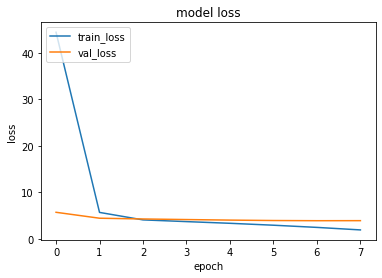

In [40]:
# 모델 결과 출력
plt.plot(history.history["loss"])
plt.plot(history.history["val_mse"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "val_loss"], loc="upper left")
plt.show()


In [41]:
pred_value = model.predict(test_model_input, 1024)
predict = np.around(pred_value)
answer=test_model_input['TOTAL_RATE']
mean_squared_error(answer,predict)

3.9850330305532617

## LGBM 추가 앙상블 모델로서 학습하기?



In [42]:
for k in CAT_FIELDS:
    Final_Train[k]=Final_Train[k].astype('category')
    
    
lgbm_train_columns = get_feature_names(fixlen_feature_columns)    
    

X_train, X_test, y_train, y_test = train_test_split(Final_Train[lgbm_train_columns],Final_Train['TOTAL_RATE'] ,test_size=0.2, random_state=156)

In [43]:
lgbm_wrapper = LGBMRegressor(n_estimators=400)
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='mae', eval_set=evals, verbose=True)

[1]	valid_0's l2: 4.43795	valid_0's l1: 1.65908
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 4.31954	valid_0's l1: 1.62981
[3]	valid_0's l2: 4.22415	valid_0's l1: 1.60373
[4]	valid_0's l2: 4.14681	valid_0's l1: 1.58055
[5]	valid_0's l2: 4.0836	valid_0's l1: 1.55952
[6]	valid_0's l2: 4.03188	valid_0's l1: 1.54074
[7]	valid_0's l2: 3.98953	valid_0's l1: 1.52416
[8]	valid_0's l2: 3.95493	valid_0's l1: 1.50959
[9]	valid_0's l2: 3.92867	valid_0's l1: 1.49804
[10]	valid_0's l2: 3.90626	valid_0's l1: 1.48749
[11]	valid_0's l2: 3.88674	valid_0's l1: 1.47791
[12]	valid_0's l2: 3.87358	valid_0's l1: 1.47004
[13]	valid_0's l2: 3.86158	valid_0's l1: 1.46299
[14]	valid_0's l2: 3.85057	valid_0's l1: 1.45665
[15]	valid_0's l2: 3.84308	valid_0's l1: 1.45117
[16]	valid_0's l2: 3.83292	valid_0's l1: 1.44563
[17]	valid_0's l2: 3.82495	valid_0's l1: 1.44083
[18]	valid_0's l2: 3.81728	valid_0's l1: 1.43637
[19]	valid_0's l2: 3.81321	valid_0's l1: 1.43265
[20]	valid_0's l

LGBMRegressor(n_estimators=400)

In [44]:
pred = lgbm_wrapper.predict(X_test)
mean_squared_error(pred,y_test.values)

3.7372123813648885

### 위에 사용한 Tree Model들의 Hyper Parameter는 설정하기 귀찮고 힘든데 Optuna로 설정해보는 것에 목적

In [47]:
import matplotlib.font_manager as fm

In [48]:

fm.get_fontconfig_fonts()
font_location = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()


In [49]:
plt.rc('font', family=font_name)
print(plt.rcParams['font.family'])

['NanumBarunGothic']


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51652 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47308 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48169 missing from current font.
  font.set_

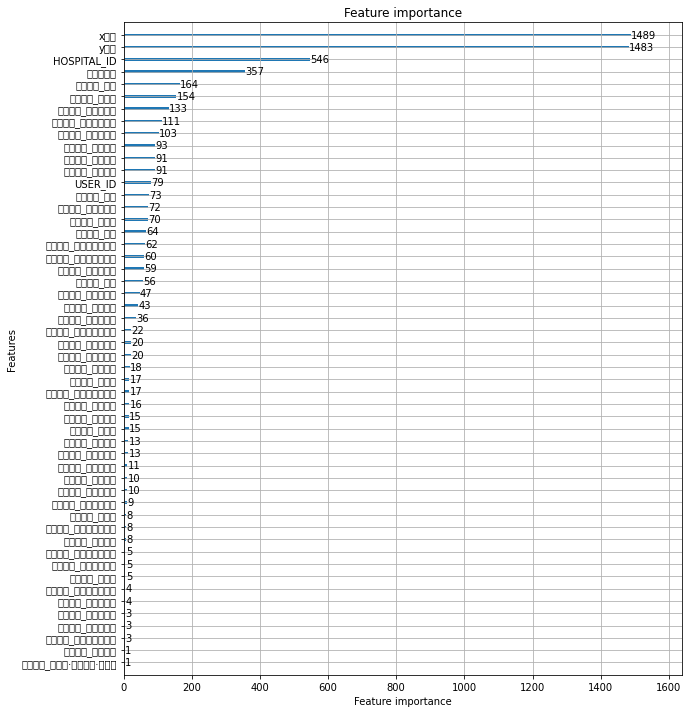

In [50]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)
plt.show()

### Optuna로 Tuning

In [51]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [66]:
sampler = TPESampler(seed=10) # 젤 많이 쓰이는 sampler, DL에서 optimizer 느낌

def objective(trial):
    dtrain = Dataset(X_train, label=y_train)
    dtest = Dataset(X_test, label=y_test)

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',3, 30),        # suggest_int 정수로 이동하면서 학습
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2), # suggest_loguniform 함수를 써 줘야 소수점을 따라 학습
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = LGBMRegressor(**param) # ** = 가변적이라는 뜻
    lgb_model = model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=25)
    mse = mean_squared_error(y_test, lgb_model.predict(X_test))
    return mse
        
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2022-12-05 08:13:21,799] A new study created in memory with name: no-name-d358813c-3d41-47d4-8840-3bda7f472a13
<ipython-input-66-833ad3f29d7a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2), # suggest_loguniform 함수를 써 줘야 소수점을 따라 학습
<ipython-input-66-833ad3f29d7a>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
[I 2022-12-05 08:13:42,645] Trial 0 finished with value: 4.583790286230395 and parameters: {'max_depth': 24, 'learning_rate': 1.3320229150659043e-08, 'n_estimators': 1938, 'min_child_samples': 76, 'sub

### 위 코드에서 파라미터 추출하고 추가 학습까지 진행해 줘야 함

In [75]:
pred = pd.read_csv('/content/drive/MyDrive/YDS/AIConnect_YDS_2/Sample_Submission.csv')
pred = pred.drop(columns = ['Unnamed: 0'])
pred

,Question_ID,Predict_Score
0,1034825_85156,1
1,201020684119_33732,1
2,1078855_203038,1
3,1501770_47123,1
4,582814_54799,1
...,...,...
1401,1405162_116235,1
1402,1405162_85781,1
1403,1405162_229060,1
1404,1410677_76169,1


In [64]:
trial_params = {'max_depth': 23, 'learning_rate': 0.00990323848202835, 'n_estimators': 846, 'min_child_samples': 24, 'subsample': 0.8701277798440029}

In [77]:
final_lgb_model = LGBMRegressor(**trial_params)
final_lgb_model.fit(X_train, y_train)
final_lgb_pred = final_lgb_model.predict(pred)

ValueError: ignored

In [69]:
X_test

,HOSPITAL_ID,시군구코드,USER_ID,진료과목_X,진료과목_가정의학과,진료과목_결핵과,진료과목_구강내과,진료과목_구강병리과,진료과목_구강악안면외과,진료과목_내과,...,진료과목_한방부인과,진료과목_한방소아과,진료과목_한방신경정신과,진료과목_한방안·이비인후·피부과,진료과목_한방응급,진료과목_한방재활의학과,진료과목_핵의학과,진료과목_흉부외과,x좌표,y좌표
4038,5455,0,8294,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.226278,0.933224
17317,5574,0,8246,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.228029,0.934064
20375,5517,0,10746,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0.227021,0.930095
44772,5046,0,26634,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.227265,0.930284
46778,3392,0,5720,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0.236107,0.930113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41444,3647,14,4755,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0.189710,0.955620
47367,4835,24,13521,0,0,0,0,0,0,0,...,1,1,1,1,0,1,0,0,0.181367,0.919767
42464,3342,20,12019,0,0,0,0,0,0,0,...,1,1,1,1,0,1,0,0,0.224844,0.932792
14807,4057,0,20377,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.225116,0.932875


In [67]:
pred

,Question_ID,Predict_Score
0,1034825_85156,1
1,201020684119_33732,1
2,1078855_203038,1
3,1501770_47123,1
4,582814_54799,1
...,...,...
1401,1405162_116235,1
1402,1405162_85781,1
1403,1405162_229060,1
1404,1410677_76169,1


ValueError: ignored

In [68]:
optuna.visualization.plot_param_importances(study_lgb)